# 4.2
INSTRUCTIONS:<br><br>
Download the Excel file here on crime data in New York State in 2013, provided by the FBI: UCR (Thinkful mirror).

Prepare this data to model with multivariable regression (including data cleaning if necessary) according to this specification:

<i>Propertycrime=α+Population+Population^2+Murder+Robbery</i><br>
<br> 
The 'population' variable is already set for you, but you will need to create the last three features. Robbery and Murder are currently continuous variables. For this model, please use these variables to create categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0. You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready. Don't forget basic data cleaning procedures, either! Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

Load:

In [2]:
crime_df = pd.read_csv("NYC_2013_crime.csv")
crime_df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0.0,NaN,3,4,16,223,53,165,5,NaN


Clean:

In [3]:
# since I'm told above that I'm only going to be using Population, binary Murder, and binary Robbery,
# I'm going to make a new df with only the relevant features and clean those.
small_df = crime_df[["City","Population", "Robbery", "Murder and\nnonnegligent\nmanslaughter"]].copy()
small_df.rename(columns={"Murder and\nnonnegligent\nmanslaughter":"Murder_manslaughter"}, inplace=True)
small_df.head()

,City,Population,Robbery,Murder_manslaughter
0,Adams Village,"1,861",0,0.0
1,Addison Town and Village,"2,577",0,0.0
2,Akron Village,"2,846",0,0.0
3,Albany,"97,956",227,8.0
4,Albion Village,"6,388",4,0.0


In [4]:
small_df.dtypes

City                    object
Population              object
Robbery                 object
Murder_manslaughter    float64
dtype: object

In [5]:
#any remaining NaNs here will be useless and have to be discarded
small_df.dropna(inplace=True)

# fix type problems
small_df["Population"] = small_df["Population"].astype(str).str.replace(",","").astype(int)
small_df["Robbery"] = small_df["Robbery"].astype(str).str.replace(",","").astype(int)
small_df["Murder_manslaughter"] = small_df["Murder_manslaughter"].astype(int)
small_df.dtypes

City                   object
Population              int64
Robbery                 int64
Murder_manslaughter     int64
dtype: object

In [6]:
small_df.head()

,City,Population,Robbery,Murder_manslaughter
0,Adams Village,1861,0,0
1,Addison Town and Village,2577,0,0
2,Akron Village,2846,0,0
3,Albany,97956,227,8
4,Albion Village,6388,4,0


In [7]:
small_df.describe()

,Population,Robbery,Murder_manslaughter
count,3.480000e+02,348.000000,348.000000
mean,4.003763e+04,72.902299,1.566092
std,4.500374e+05,1031.032873,18.303673
min,5.260000e+02,0.000000,0.000000
25%,3.003000e+03,0.000000,0.000000
50%,7.233500e+03,1.000000,0.000000
75%,1.842750e+04,5.000000,0.000000
max,8.396126e+06,19170.000000,335.000000


In [8]:
small_df[small_df["Population"]>100000]

,City,Population,Robbery,Murder_manslaughter
7,Amherst Town,118296,31,1
35,Buffalo,258789,1322,47
216,New York,8396126,19170,335
272,Rochester,210562,918,42
310,Syracuse,143834,400,21
346,Yonkers,199134,390,6


NYC is going to be a huge outlier in all regards. Let's axe it from the list of cities.

In [9]:
small_df = small_df[small_df["City"]!="New York"]

Now if we take a look at the numbers, the maxima look a lot more reasonable.

In [10]:
small_df.describe()

,Population,Robbery,Murder_manslaughter
count,347.000000,347.000000,347.000000
mean,15956.685879,17.867435,0.605187
std,27080.218837,94.972492,3.707090
min,526.000000,0.000000,0.000000
25%,2997.000000,0.000000,0.000000
50%,7187.000000,1.000000,0.000000
75%,18160.500000,5.000000,0.000000
max,258789.000000,1322.000000,47.000000


Here are some plots to see the basic distribution and check for anomalies.  We can see that for each column, there's a large majority of cities with very low values, and a tail trailing out to the right.  

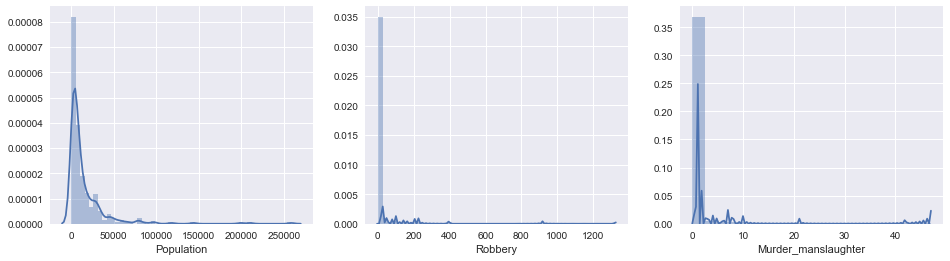

In [11]:
plt.figure(figsize=(16,4))
plt.subplot(131)
sns.distplot(small_df["Population"])
plt.subplot(132)
sns.distplot(small_df["Robbery"])
plt.subplot(133)
sns.distplot(small_df["Murder_manslaughter"])
plt.show()


If we draw some plots without the very lowest values, we can get a better view of the distribution.  There seem to be two main outliers in robberies and murders.

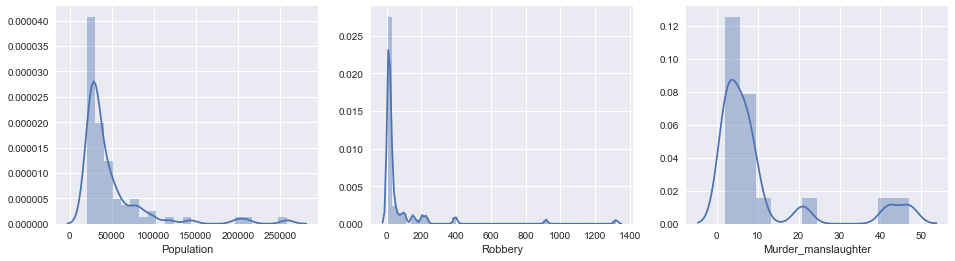

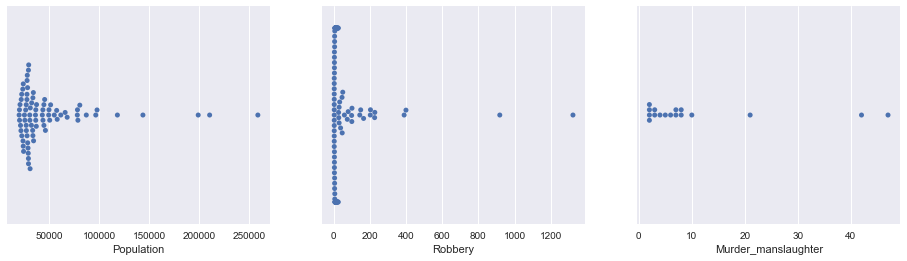

In [12]:
plt.figure(figsize=(16,4))
plt.subplot(131)
sns.distplot(small_df[small_df["Population"]>20000]["Population"])
plt.subplot(132)
sns.distplot(small_df[small_df["Robbery"]>5]["Robbery"])
plt.subplot(133)
sns.distplot(small_df[small_df["Murder_manslaughter"]>1]["Murder_manslaughter"])
plt.show()

plt.figure(figsize=(16,4))
plt.subplot(131)
sns.swarmplot(small_df[small_df["Population"]>20000]["Population"])
plt.subplot(132)
sns.swarmplot(small_df[small_df["Robbery"]>3]["Robbery"])
plt.subplot(133)
sns.swarmplot(small_df[small_df["Murder_manslaughter"]>1]["Murder_manslaughter"])
plt.show()

And those outliers are... Buffalo and Rochester.  We'll leave them in for the moment, but we may want to try our regression both with and without them.

In [13]:
print(small_df[small_df["Robbery"]>800]["City"])
print(small_df[small_df["Murder_manslaughter"]>40]["City"])

35       Buffalo
272    Rochester
Name: City, dtype: object
35       Buffalo
272    Rochester
Name: City, dtype: object


Finally, let's add the requested binary features.

In [14]:
small_df["had_Murder"] = (small_df["Murder_manslaughter"] > 0)
small_df['had_Robbery'] = (small_df['Robbery'] > 0)
small_df.head()

,City,Population,Robbery,Murder_manslaughter,had_Murder,had_Robbery
0,Adams Village,1861,0,0,False,False
1,Addison Town and Village,2577,0,0,False,False
2,Akron Village,2846,0,0,False,False
3,Albany,97956,227,8,True,True
4,Albion Village,6388,4,0,False,True
